<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S6/blob/master/assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

# Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


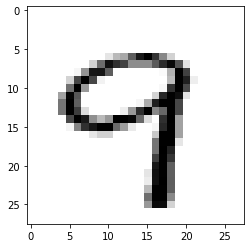

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

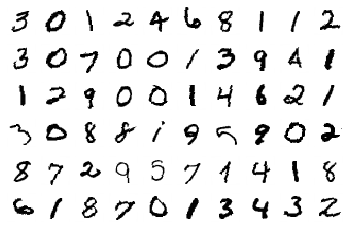

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model

In [0]:
dropout_value = 0.06
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

Viewing model summary is important. There is no in-built model visualizer in pyTorch. take external help from torychsummary.

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm
import numpy as np

class ModelTrain():
  def __init__(self):
    #to monitor training and test losses
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    # initialize tracker for minimum validation loss
    self.valid_loss_min = np.Inf # set initial "min" to infinity

  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prep model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)   # forward pass: compute predicted outputs by passing inputs to the model

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 regularization
      if L1lambda is not None:
        #l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        for param in model.parameters():
          #reg_loss += l1_crit(param)
          reg_loss += torch.sum(param.abs())
        loss += L1lambda * reg_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])


  ####VAlidate the model ####
  def test(self, model, device, test_loader,filename):
    #valid_loss_min = np.Inf
    model.eval()  # prep model for evaluation
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    self.test_acc.append(100. * correct / len(test_loader.dataset))

    # save model if validation loss has decreased
    if test_loss <= self.valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        self.valid_loss_min,
        test_loss))
        torch.save(model.state_dict(), filename)
        self.valid_loss_min = test_loss


# Let's Train and test our model
## Model without L1 and L2 regularizations

In [12]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#first model
#without L1 and L2 regularization
model1 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model1.train(model, device, train_loader, optimizer, epoch, scheduler)
    model1.test(model, device, test_loader,"model1.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09696400910615921 Batch_id=468 Accuracy=80.05: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9752/10000 (97.52%)

Validation loss decreased (inf --> 0.092375).  Saving model ...
EPOCH: 1


Loss=0.06273490190505981 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9799/10000 (97.99%)

Validation loss decreased (0.092375 --> 0.065496).  Saving model ...
EPOCH: 2


Loss=0.048265229910612106 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9884/10000 (98.84%)

Validation loss decreased (0.065496 --> 0.038360).  Saving model ...
EPOCH: 3


Loss=0.1068289503455162 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.08927110582590103 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

Validation loss decreased (0.038360 --> 0.026855).  Saving model ...
EPOCH: 5


Loss=0.046137552708387375 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.00892262626439333 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.033582840114831924 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

Validation loss decreased (0.026855 --> 0.023399).  Saving model ...
EPOCH: 8


Loss=0.05407389998435974 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

Validation loss decreased (0.023399 --> 0.022906).  Saving model ...
EPOCH: 9


Loss=0.04108385741710663 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 41.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.07195841521024704 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9921/10000 (99.21%)

Validation loss decreased (0.022906 --> 0.022028).  Saving model ...
EPOCH: 11


Loss=0.09547575563192368 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

Validation loss decreased (0.022028 --> 0.022017).  Saving model ...
EPOCH: 12


Loss=0.053435370326042175 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.03152656927704811 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.04889422655105591 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9921/10000 (99.21%)

Validation loss decreased (0.022017 --> 0.021940).  Saving model ...
EPOCH: 15


Loss=0.05149034783244133 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)

Validation loss decreased (0.021940 --> 0.018665).  Saving model ...
EPOCH: 16


Loss=0.041311491280794144 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.07958768308162689 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

Validation loss decreased (0.018665 --> 0.018489).  Saving model ...
EPOCH: 18


Loss=0.007064516190439463 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.023472988978028297 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9936/10000 (99.36%)

Validation loss decreased (0.018489 --> 0.017340).  Saving model ...
EPOCH: 20


Loss=0.06477919220924377 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.008493651635944843 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.01637643575668335 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.041814643889665604 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)

Validation loss decreased (0.017340 --> 0.016541).  Saving model ...
EPOCH: 24


Loss=0.0059195407666265965 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9945/10000 (99.45%)

EPOCH: 25


Loss=0.11636471003293991 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9949/10000 (99.49%)

Validation loss decreased (0.016541 --> 0.015378).  Saving model ...
EPOCH: 26


Loss=0.0026168127078562975 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9950/10000 (99.50%)

Validation loss decreased (0.015378 --> 0.015373).  Saving model ...
EPOCH: 27


Loss=0.02286309003829956 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.015373 --> 0.014918).  Saving model ...
EPOCH: 28


Loss=0.018837830051779747 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9955/10000 (99.55%)

Validation loss decreased (0.014918 --> 0.014791).  Saving model ...
EPOCH: 29


Loss=0.0016128718852996826 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 9955/10000 (99.55%)

Validation loss decreased (0.014791 --> 0.014109).  Saving model ...
EPOCH: 30


Loss=0.03656167536973953 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9949/10000 (99.49%)

EPOCH: 31


Loss=0.002729088068008423 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9949/10000 (99.49%)

EPOCH: 32


Loss=0.012029792182147503 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9950/10000 (99.50%)

EPOCH: 33


Loss=0.031573861837387085 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9945/10000 (99.45%)

EPOCH: 34


Loss=0.030577823519706726 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9956/10000 (99.56%)

Validation loss decreased (0.014109 --> 0.014014).  Saving model ...
EPOCH: 35


Loss=0.04817904159426689 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.014014 --> 0.013861).  Saving model ...
EPOCH: 36


Loss=0.008058409206569195 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 9950/10000 (99.50%)

EPOCH: 37


Loss=0.011983375065028667 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.013861 --> 0.013728).  Saving model ...
EPOCH: 38


Loss=0.02257283590734005 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.013728 --> 0.013520).  Saving model ...
EPOCH: 39


Loss=0.004570146556943655 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]



Test set: Average loss: 0.0132, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.013520 --> 0.013214).  Saving model ...


# Model with L1 Regualrization

In [13]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#2 model
#with L1 regularization
model2 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model2.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model2.test(model, device, test_loader,"model2.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.16409340500831604 Batch_id=468 Accuracy=82.08: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9802/10000 (98.02%)

Validation loss decreased (inf --> 0.080365).  Saving model ...
EPOCH: 1


Loss=0.11018446832895279 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9846/10000 (98.46%)

Validation loss decreased (0.080365 --> 0.054752).  Saving model ...
EPOCH: 2


Loss=0.028520431369543076 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9870/10000 (98.70%)

Validation loss decreased (0.054752 --> 0.044018).  Saving model ...
EPOCH: 3


Loss=0.048456739634275436 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9892/10000 (98.92%)

Validation loss decreased (0.044018 --> 0.036450).  Saving model ...
EPOCH: 4


Loss=0.09002936631441116 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 36.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9866/10000 (98.66%)

EPOCH: 5


Loss=0.1508602648973465 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9883/10000 (98.83%)

Validation loss decreased (0.036450 --> 0.034666).  Saving model ...
EPOCH: 6


Loss=0.10117250680923462 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9919/10000 (99.19%)

Validation loss decreased (0.034666 --> 0.027991).  Saving model ...
EPOCH: 7


Loss=0.06798869371414185 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9909/10000 (99.09%)

Validation loss decreased (0.027991 --> 0.027051).  Saving model ...
EPOCH: 8


Loss=0.04100736230611801 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

Validation loss decreased (0.027051 --> 0.021934).  Saving model ...
EPOCH: 9


Loss=0.035415299236774445 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.05012580007314682 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.17712989449501038 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9900/10000 (99.00%)

EPOCH: 12


Loss=0.041203662753105164 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.04852242022752762 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.04414311796426773 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 37.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.03539996221661568 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.032010115683078766 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

Validation loss decreased (0.021934 --> 0.020856).  Saving model ...
EPOCH: 17


Loss=0.07511766999959946 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.01475171372294426 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.01873118244111538 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.035262010991573334 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.025753237307071686 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

Validation loss decreased (0.020856 --> 0.020019).  Saving model ...
EPOCH: 22


Loss=0.058696504682302475 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.05849684029817581 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

Validation loss decreased (0.020019 --> 0.018153).  Saving model ...
EPOCH: 24


Loss=0.02135644480586052 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.048327185213565826 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 26


Loss=0.03779049590229988 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.018153 --> 0.017734).  Saving model ...
EPOCH: 27


Loss=0.028193360194563866 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9940/10000 (99.40%)

Validation loss decreased (0.017734 --> 0.017350).  Saving model ...
EPOCH: 28


Loss=0.016019200906157494 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)

EPOCH: 29


Loss=0.02651723474264145 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

EPOCH: 30


Loss=0.017998289316892624 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

Validation loss decreased (0.017350 --> 0.016720).  Saving model ...
EPOCH: 31


Loss=0.08619820326566696 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.016720 --> 0.016321).  Saving model ...
EPOCH: 32


Loss=0.019976327195763588 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 33


Loss=0.04213222861289978 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9954/10000 (99.54%)

Validation loss decreased (0.016321 --> 0.014794).  Saving model ...
EPOCH: 34


Loss=0.04204332083463669 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.02338242158293724 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.015334447845816612 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9949/10000 (99.49%)

EPOCH: 37


Loss=0.023569341748952866 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9950/10000 (99.50%)

EPOCH: 38


Loss=0.02475345879793167 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9954/10000 (99.54%)

EPOCH: 39


Loss=0.03710012510418892 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]



Test set: Average loss: 0.0151, Accuracy: 9953/10000 (99.53%)



# Model with L2 Regularization

In [14]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#3 model
#without L1 and L2 regularization
model3 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model3.train(model, device, train_loader, optimizer, epoch, scheduler)
    model3.test(model, device, test_loader,"model3.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1768478900194168 Batch_id=468 Accuracy=77.89: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1289, Accuracy: 9634/10000 (96.34%)

Validation loss decreased (inf --> 0.128890).  Saving model ...
EPOCH: 1


Loss=0.1604875773191452 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9827/10000 (98.27%)

Validation loss decreased (0.128890 --> 0.055637).  Saving model ...
EPOCH: 2


Loss=0.07210244983434677 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0592, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.11448324471712112 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:13<00:00, 34.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9896/10000 (98.96%)

Validation loss decreased (0.055637 --> 0.035430).  Saving model ...
EPOCH: 4


Loss=0.06776405870914459 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9896/10000 (98.96%)

Validation loss decreased (0.035430 --> 0.034059).  Saving model ...
EPOCH: 5


Loss=0.03778314217925072 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9902/10000 (99.02%)

Validation loss decreased (0.034059 --> 0.032367).  Saving model ...
EPOCH: 6


Loss=0.0936557874083519 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 34.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9884/10000 (98.84%)

EPOCH: 7


Loss=0.035508669912815094 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:13<00:00, 34.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.042720306664705276 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

Validation loss decreased (0.032367 --> 0.022426).  Saving model ...
EPOCH: 9


Loss=0.04210345447063446 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9901/10000 (99.01%)

EPOCH: 10


Loss=0.0824483260512352 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

Validation loss decreased (0.022426 --> 0.021424).  Saving model ...
EPOCH: 11


Loss=0.03696197643876076 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Loss=0.05106114223599434 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.015125125646591187 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.06324867904186249 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.02930600941181183 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

Validation loss decreased (0.021424 --> 0.020460).  Saving model ...
EPOCH: 16


Loss=0.01799243688583374 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.01819918490946293 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 39.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


Loss=0.011889730580151081 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9947/10000 (99.47%)

Validation loss decreased (0.020460 --> 0.018929).  Saving model ...
EPOCH: 19


Loss=0.03188203275203705 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Loss=0.01183021068572998 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.018929 --> 0.018488).  Saving model ...
EPOCH: 21


Loss=0.0132373021915555 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 36.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9947/10000 (99.47%)

Validation loss decreased (0.018488 --> 0.016998).  Saving model ...
EPOCH: 22


Loss=0.0043161711655557156 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 42.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.02979459799826145 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.041360318660736084 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.014563441276550293 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 26


Loss=0.009534105658531189 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 27


Loss=0.012594525702297688 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)

EPOCH: 28


Loss=0.014979531057178974 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 29


Loss=0.027721747756004333 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.016998 --> 0.016046).  Saving model ...
EPOCH: 30


Loss=0.02586534060537815 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.016046 --> 0.015455).  Saving model ...
EPOCH: 31


Loss=0.02033771574497223 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.015455 --> 0.014973).  Saving model ...
EPOCH: 32


Loss=0.01297780405730009 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.07057801634073257 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9952/10000 (99.52%)

EPOCH: 34


Loss=0.009051874279975891 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 9957/10000 (99.57%)

Validation loss decreased (0.014973 --> 0.013878).  Saving model ...
EPOCH: 35


Loss=0.003813917515799403 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 9954/10000 (99.54%)

EPOCH: 36


Loss=0.020319556817412376 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9955/10000 (99.55%)

EPOCH: 37


Loss=0.010637025348842144 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 39.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 9958/10000 (99.58%)

EPOCH: 38


Loss=0.008792087435722351 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 9958/10000 (99.58%)

EPOCH: 39


Loss=0.0038004566449671984 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]



Test set: Average loss: 0.0131, Accuracy: 9961/10000 (99.61%)

Validation loss decreased (0.013878 --> 0.013050).  Saving model ...


# Model with L1 and L2 regularization 

In [15]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=40)

#4 model
#without L1 and L2 regularization
model4 = ModelTrain()
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model4.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model4.test(model, device, test_loader,"model4.pt")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2134357988834381 Batch_id=468 Accuracy=82.63: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1071, Accuracy: 9728/10000 (97.28%)

Validation loss decreased (inf --> 0.107082).  Saving model ...
EPOCH: 1


Loss=0.037043891847133636 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9876/10000 (98.76%)

Validation loss decreased (0.107082 --> 0.040801).  Saving model ...
EPOCH: 2


Loss=0.11426476389169693 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9882/10000 (98.82%)

Validation loss decreased (0.040801 --> 0.038583).  Saving model ...
EPOCH: 3


Loss=0.01597747765481472 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9792/10000 (97.92%)

EPOCH: 4


Loss=0.017106730490922928 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9864/10000 (98.64%)

EPOCH: 5


Loss=0.12292946875095367 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 40.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9910/10000 (99.10%)

Validation loss decreased (0.038583 --> 0.028954).  Saving model ...
EPOCH: 6


Loss=0.04789826273918152 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9874/10000 (98.74%)

EPOCH: 7


Loss=0.07254590094089508 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

Validation loss decreased (0.028954 --> 0.028492).  Saving model ...
EPOCH: 8


Loss=0.06116119399666786 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

Validation loss decreased (0.028492 --> 0.027395).  Saving model ...
EPOCH: 9


Loss=0.027726048603653908 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.15%)

Validation loss decreased (0.027395 --> 0.025113).  Saving model ...
EPOCH: 10


Loss=0.03295829892158508 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.03817303478717804 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9907/10000 (99.07%)

EPOCH: 12


Loss=0.02964702621102333 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


Loss=0.09873878955841064 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.07702679187059402 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

Validation loss decreased (0.025113 --> 0.022190).  Saving model ...
EPOCH: 15


Loss=0.04207906872034073 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.01526559703052044 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9871/10000 (98.71%)

EPOCH: 17


Loss=0.022822076454758644 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.03574604168534279 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 39.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9915/10000 (99.15%)

EPOCH: 19


Loss=0.02886529453098774 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Loss=0.017933079972863197 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9908/10000 (99.08%)

EPOCH: 21


Loss=0.03249785304069519 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 22


Loss=0.08505281060934067 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Loss=0.09452592581510544 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9936/10000 (99.36%)

Validation loss decreased (0.022190 --> 0.019985).  Saving model ...
EPOCH: 24


Loss=0.020358387380838394 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.05681188404560089 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.039259038865566254 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)

EPOCH: 27


Loss=0.014638606458902359 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 28


Loss=0.023735273629426956 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 29


Loss=0.07697372883558273 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)

EPOCH: 30


Loss=0.016071530058979988 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Loss=0.038962408900260925 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

Validation loss decreased (0.019985 --> 0.019733).  Saving model ...
EPOCH: 32


Loss=0.11349178850650787 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

Validation loss decreased (0.019733 --> 0.018763).  Saving model ...
EPOCH: 33


Loss=0.018531614914536476 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 31.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

Validation loss decreased (0.018763 --> 0.017920).  Saving model ...
EPOCH: 34


Loss=0.019513752311468124 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

Validation loss decreased (0.017920 --> 0.017088).  Saving model ...
EPOCH: 35


Loss=0.017841452732682228 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9947/10000 (99.47%)

Validation loss decreased (0.017088 --> 0.016887).  Saving model ...
EPOCH: 36


Loss=0.011667635291814804 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 41.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9950/10000 (99.50%)

Validation loss decreased (0.016887 --> 0.015745).  Saving model ...
EPOCH: 37


Loss=0.021846814081072807 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9953/10000 (99.53%)

Validation loss decreased (0.015745 --> 0.015589).  Saving model ...
EPOCH: 38


Loss=0.014358960092067719 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.015589 --> 0.014967).  Saving model ...
EPOCH: 39


Loss=0.013487662188708782 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]



Test set: Average loss: 0.0153, Accuracy: 9951/10000 (99.51%)



# Graphs

In [16]:
#dir(model1)
print(len(model1.train_epoch_end), model1.train_epoch_end)
print(len(model2.train_epoch_end), model2.train_epoch_end)
print(len(model3.train_epoch_end), model3.train_epoch_end)
print(len(model4.train_epoch_end), model4.train_epoch_end)

40 [80.05333333333333, 96.92833333333333, 97.725, 97.945, 98.16333333333333, 98.22333333333333, 98.38166666666666, 98.47833333333334, 98.57833333333333, 98.6, 98.70333333333333, 98.79, 98.82166666666667, 98.84833333333333, 98.89166666666667, 98.90166666666667, 98.89, 98.98, 99.01166666666667, 98.96, 99.04333333333334, 99.00333333333333, 99.12666666666667, 99.13833333333334, 99.12166666666667, 99.18833333333333, 99.21166666666667, 99.19, 99.23, 99.27, 99.31666666666666, 99.27666666666667, 99.33166666666666, 99.37833333333333, 99.35333333333334, 99.36166666666666, 99.40833333333333, 99.38166666666666, 99.415, 99.40166666666667]
40 [82.08, 97.09833333333333, 97.69333333333333, 97.905, 97.97833333333334, 98.15666666666667, 98.44, 98.47, 98.53333333333333, 98.56833333333333, 98.65666666666667, 98.675, 98.73666666666666, 98.72666666666667, 98.76166666666667, 98.82666666666667, 98.86333333333333, 98.88833333333334, 98.87833333333333, 98.945, 99.0, 98.94833333333334, 99.02, 99.06666666666666, 

## Plotting Validation Accuracy of 4 Models

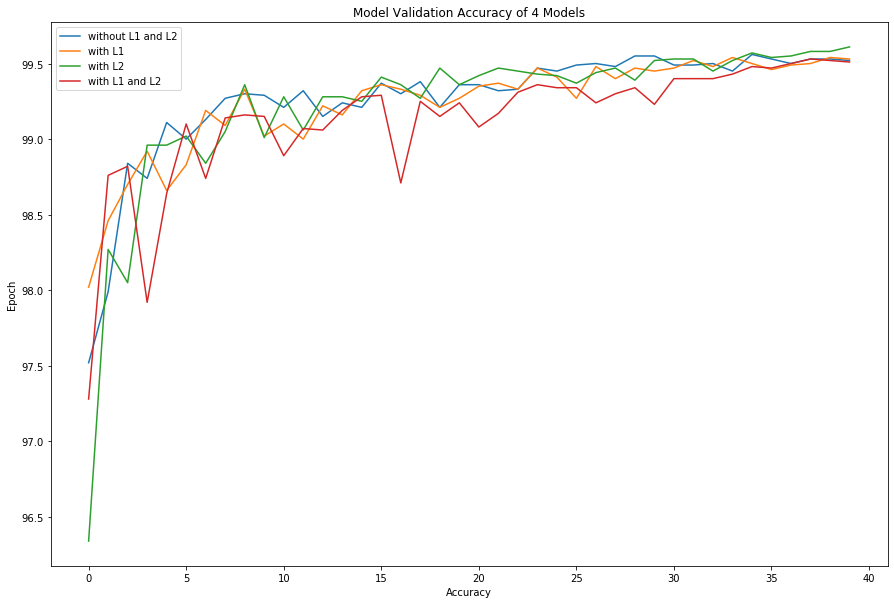

In [17]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_acc)
ax.plot(model2.test_acc)
ax.plot(model3.test_acc)
ax.plot(model4.test_acc)
ax.set(title="Model Validation Accuracy of 4 Models", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("Accuracyof4models.png")
plt.show()


## Plotting Validation Loss of Four Models

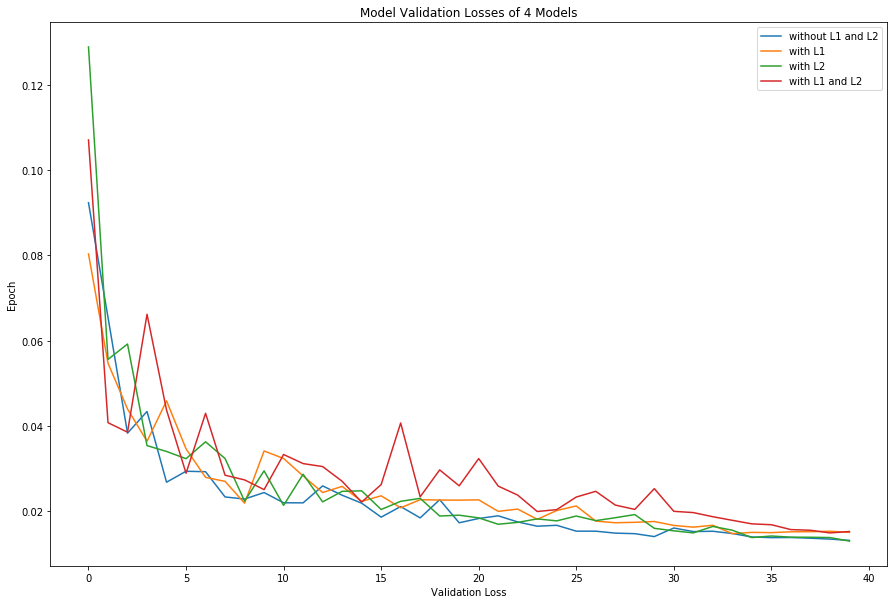

In [18]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_losses)
ax.plot(model2.test_losses)
ax.plot(model3.test_losses)
ax.plot(model4.test_losses)
ax.set(title="Model Validation Losses of 4 Models", xlabel="Validation Loss", ylabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2'], loc='best')
plt.savefig("ValidationLossof4models.png")
plt.show()


## Function to plot Misclassified images

In [0]:
def PlotMisclassifiedImages(model, filename):
  
  model = model.to(device)
  # obtain one batch of test images
  dataiter = iter(test_loader)
  c=0
  fig = plt.figure(figsize=(14,14 ))
  
  while c<25:
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    
    output = model(images)  # get sample outputs

    _, preds = torch.max(output, 1)   # convert output probabilities to predicted class
    images = images.cpu().numpy() # prep images for display
    
    for idx in np.arange(128):
      if preds[idx]!=labels[idx] :
        ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
        c=c+1
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("P-{} (T-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
        if c==25:
          break
    plt.savefig(filename)



----Misclassified images by a Model without L1 and L2 regualatization----


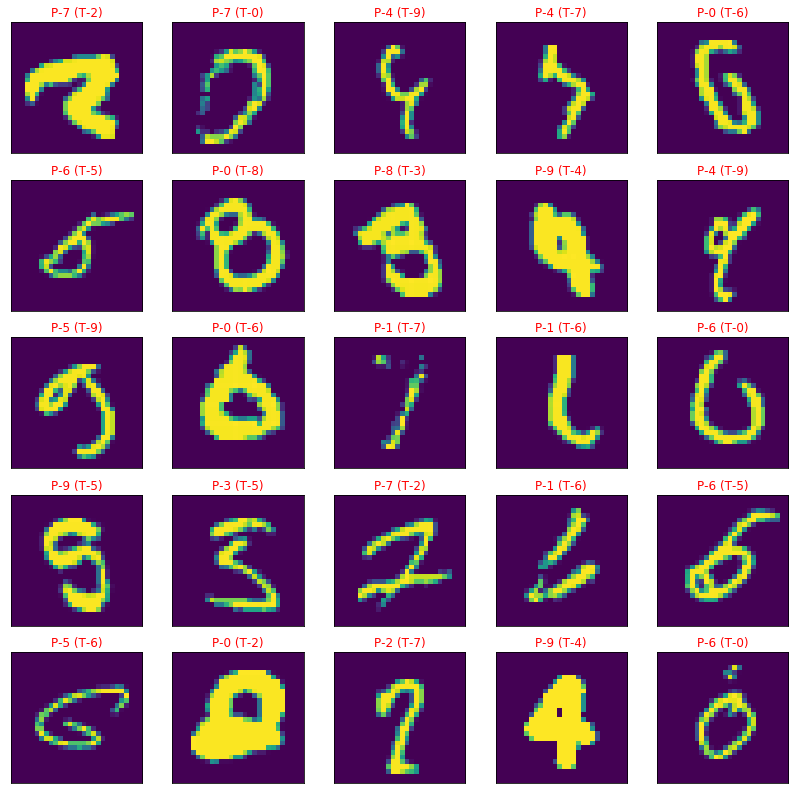

In [22]:
#Load the first model with lowest validation loss
print("----Misclassified images by a Model without L1 and L2 regualatization----")
model.load_state_dict(torch.load("model1.pt")) 
PlotMisclassifiedImages(model, filename="WithoutL1andL2.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L1 regualatization----


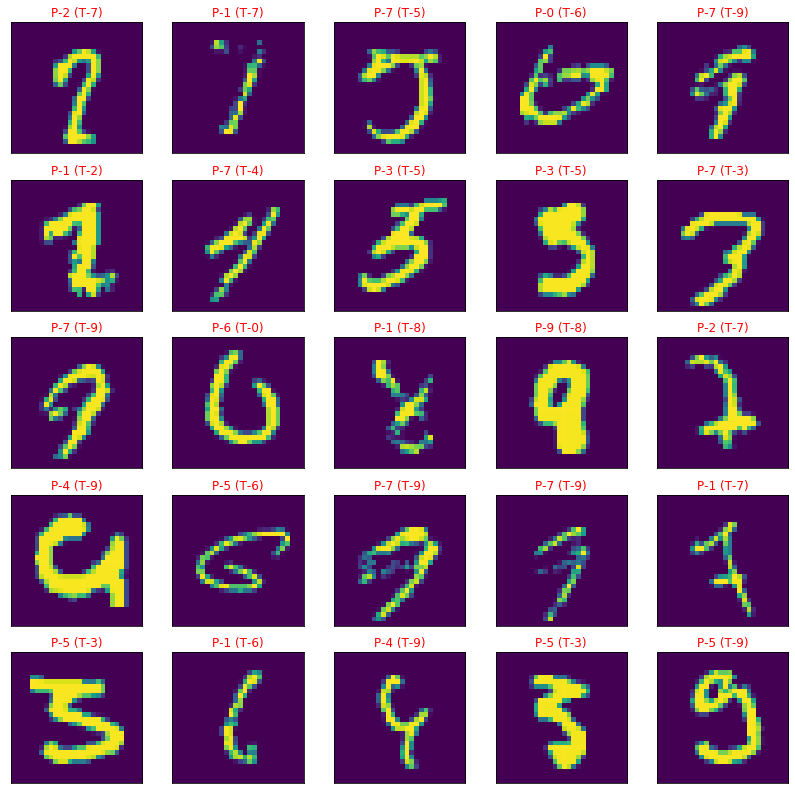

In [23]:
#Load the second model with lowest validation loss
print("----Misclassified images by a Model with L1 regualatization----")
model.load_state_dict(torch.load("model2.pt")) 
PlotMisclassifiedImages(model, filename="WithL1.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L2 regualatization----


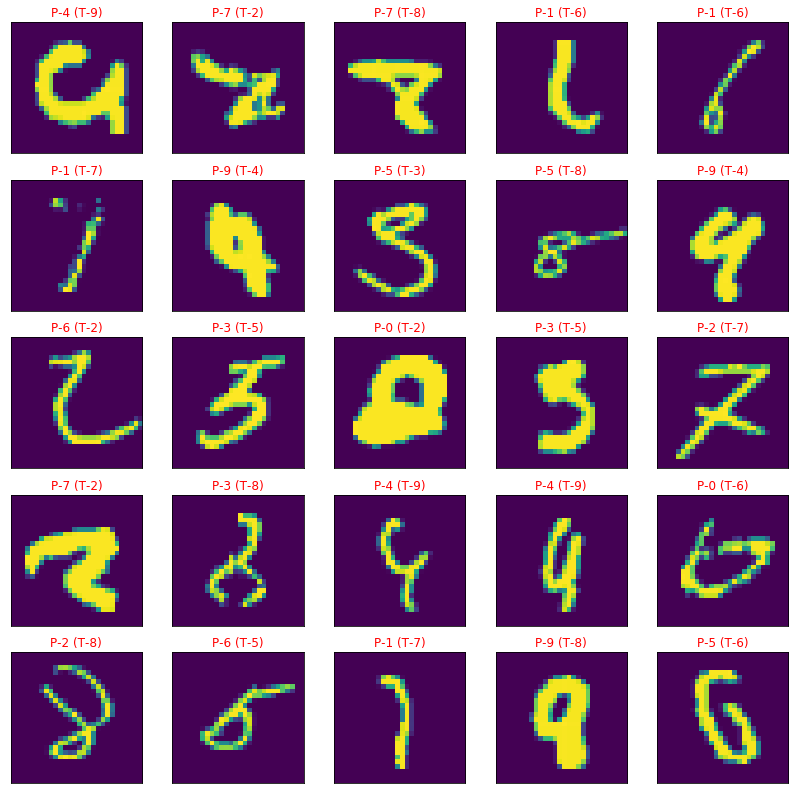

In [24]:
#Load the third model with lowest validation loss
print("----Misclassified images by a Model with L2 regualatization----")
model.load_state_dict(torch.load("model3.pt")) 
PlotMisclassifiedImages(model, filename="WithL2.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L1 and L2 regualatization----


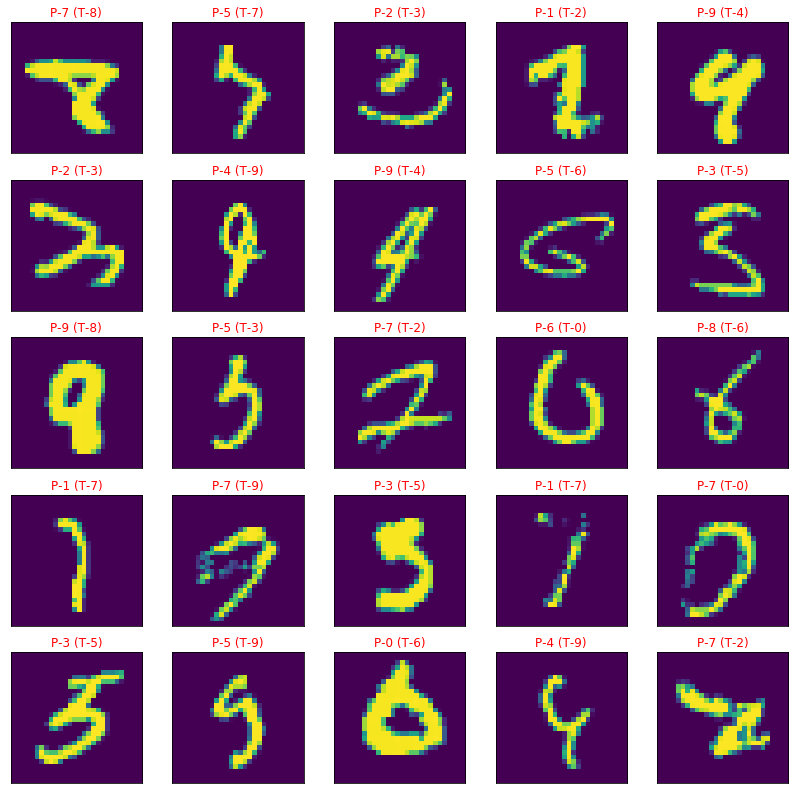

In [25]:
#Load the Fourth model with lowest validation loss
print("----Misclassified images by a Model with L1 and L2 regualatization----")
model.load_state_dict(torch.load("model4.pt")) 
PlotMisclassifiedImages(model, filename="WithL1andL2.png")  #25 misclassified images and save it in a file.

group members: Mounika, Meenakhi, Vivek